In [67]:
import numpy as np 
import pandas as pd 

import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors

import tensorflow as tf


# load data

In [68]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics 
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [69]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [70]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]
  
  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [71]:
BATCH_SIZE = 32
SAMPLE_SIZE = 64

train_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train*', 
    data_size=64, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

validation_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_eval*', 
    data_size=64, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

test_dataset = get_dataset('/kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_test*',
    data_size=64, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

In [72]:
for x, y in train_dataset.take(1):
    print(x.shape, y.shape)

for x, y in validation_dataset.take(1):
    print(x.shape, y.shape)

(32, 64, 64, 12) (32, 64, 64, 1)
(32, 64, 64, 12) (32, 64, 64, 1)


# convert to torch ( i dont know how to tensor flow)

In [73]:
import tensorflow as tf
import torch
from torch.utils.data import Dataset



class TFToTorchDataset(Dataset):
    def __init__(self, tf_dataset, clean=False):
        self.samples = []
        for x, y in tf_dataset.as_numpy_iterator():
            for i in range(x.shape[0]):
                # Convert x: (32, 32, 12) → (12, 32, 32)
                x_i = tf.transpose(x[i], perm=[2, 0, 1]).numpy()
                # Convert y: (32, 32, 1) → (1, 32, 32)
                y_i = tf.transpose(y[i], perm=[2, 0, 1]).numpy()
                
                if clean:
                    if (y_i == -1).any():
                        continue  # Skip this sample
                self.samples.append((
                    torch.tensor(x_i, dtype=torch.float32),
                    torch.tensor(y_i, dtype=torch.float32)
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [74]:
torch_dataset = TFToTorchDataset(train_dataset, clean=True)
train_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=32, shuffle=True)

torch_dataset_val =  TFToTorchDataset(validation_dataset, clean=True)
val_loader = torch.utils.data.DataLoader(torch_dataset_val, batch_size=32, shuffle=True)

In [75]:
N = 5   
dataiter = iter(train_loader)

image_list = []
label_list = []
#assume batch size equal to 1, otherwise divide N by batch size
for i in range(0, N): 
  image, label = next(dataiter)
  image_list.append(image)
  label_list.append(label)

64
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


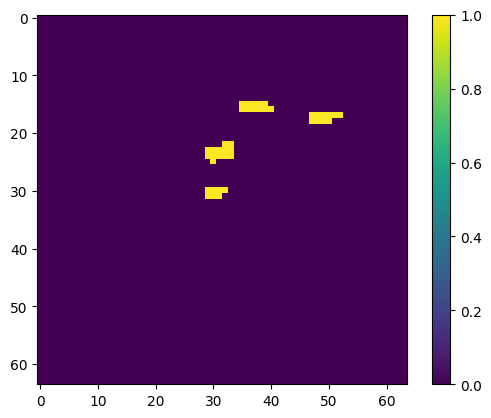

In [76]:
print(len(label_list[0][0][0][0]))
# print(label_list[0][0])
plt.imshow(label_list[4][0][0], cmap='viridis', interpolation='nearest')
plt.colorbar()  
plt.show()


# fully conv model

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))

        # Bottleneck
        b = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.up3(b)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))

        # return torch.sigmoid(self.output_layer(d1))
        return self.output_layer(d1)


In [78]:
import matplotlib.pyplot as plt

def show_prediction(model, val_loader):
    model.eval()
    with torch.no_grad():
        x_val, y_val = next(iter(val_loader))
        x_val, y_val = x_val.to(device), y_val.to(device)
        y_val = (y_val == 1).float()

        pred = model(x_val)
        pred_bin = (pred > 0.5).float()

        # Show first sample
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(x_val[0, 11].cpu(), cmap='gray')
        axs[0].set_title("Previous Fire Mask")
        axs[1].imshow(y_val[0, 0].cpu(), cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(pred_bin[0, 0].cpu(), cmap='gray')
        axs[2].set_title("Prediction")
        for ax in axs:
            ax.axis('off')
        plt.show()


In [79]:
def compute_iou(pred, target, threshold=0.5, eps=1e-6):
    pred_bin = (pred > threshold).float()
    target_bin = (target > 0.5).float()

    intersection = (pred_bin * target_bin).sum(dim=(1, 2, 3))
    union = (pred_bin + target_bin - pred_bin * target_bin).sum(dim=(1, 2, 3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def compute_accuracy(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    correct = (pred_bin == target).float()
    return correct.mean().item()


In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# criterion = nn.BCELoss()
# use instead bc we have class imbalance
weight_value = 0.85/0.15 # TODO pull the real percent background, percent fire from the dataset, i just guess 15% fire
pos_weight = torch.tensor([weight_value], device=device) 
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    # === Validation ===
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    total_acc = 0.0
    n_samples = 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_val = (y_val == 1).float()
    
            pred_val = torch.sigmoid(model(x_val))
            loss = criterion(pred_val, y_val)
            val_loss += loss.item() * x_val.size(0)
    
            # Metrics
            batch_iou = compute_iou(pred_val, y_val)
            batch_acc = compute_accuracy(pred_val, y_val)
    
            total_iou += batch_iou * x_val.size(0)
            total_acc += batch_acc * x_val.size(0)
            n_samples += x_val.size(0)
    
    val_loss /= len(val_loader.dataset)
    mean_iou = total_iou / n_samples
    mean_acc = total_acc / n_samples


    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | "
      f"Val Loss: {val_loss:.4f} | IoU: {mean_iou:.4f} | Acc: {mean_acc:.4f}")



Epoch  1 | Train Loss: 0.3343 | Val Loss: 0.8166 | IoU: 0.1834 | Acc: 0.9679
Epoch  2 | Train Loss: 0.2051 | Val Loss: 0.7850 | IoU: 0.2273 | Acc: 0.9731
Epoch  3 | Train Loss: 0.1584 | Val Loss: 0.7667 | IoU: 0.2270 | Acc: 0.9747
Epoch  4 | Train Loss: 0.1330 | Val Loss: 0.7610 | IoU: 0.2240 | Acc: 0.9671
Epoch  5 | Train Loss: 0.1179 | Val Loss: 0.7528 | IoU: 0.2363 | Acc: 0.9774
Epoch  6 | Train Loss: 0.1081 | Val Loss: 0.7497 | IoU: 0.2424 | Acc: 0.9797
Epoch  7 | Train Loss: 0.1003 | Val Loss: 0.7480 | IoU: 0.2432 | Acc: 0.9739
Epoch  8 | Train Loss: 0.0934 | Val Loss: 0.7454 | IoU: 0.2530 | Acc: 0.9795
Epoch  9 | Train Loss: 0.0887 | Val Loss: 0.7452 | IoU: 0.2511 | Acc: 0.9762
Epoch 10 | Train Loss: 0.0832 | Val Loss: 0.7437 | IoU: 0.2487 | Acc: 0.9801


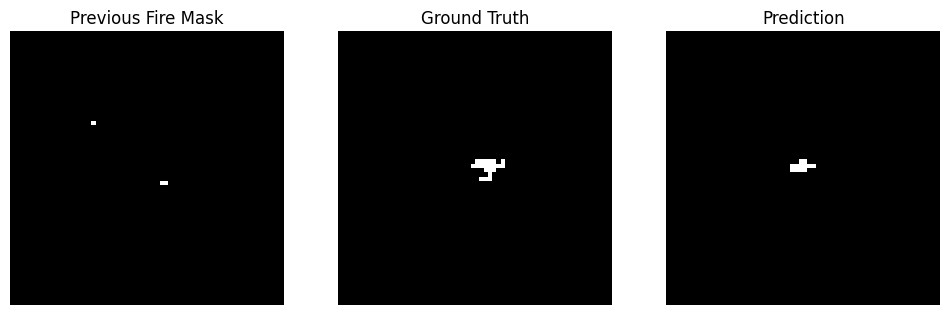

In [87]:
show_prediction(model, val_loader)

# vision transformer (IGNORE)

In [97]:
# import torch
# import torch.nn as nn
# from torchvision.models.vision_transformer import VisionTransformer

# class FireMaskViT(nn.Module):
#     def __init__(self, input_channels, image_size=64, patch_size=8, num_classes=1, hidden_dim=768, num_layers=12, num_heads=12):
#         super().__init__()

#         assert image_size % patch_size == 0, "image_size must be divisible by patch_size"

#         num_patches = (image_size // patch_size) ** 2
        
#         # VisionTransformer expects 3 input channels → we re-define input projection
#         self.vit = VisionTransformer(
#             image_size=image_size,
#             patch_size=patch_size,
#             num_layers=num_layers,
#             num_heads=num_heads,
#             hidden_dim=hidden_dim,
#             mlp_dim=hidden_dim * 4,
#             num_classes=0,  # no classification head
#         )

#         # Replace input projection layer to accept input_channels instead of 3
#         self.vit.conv_proj = nn.Conv2d(input_channels, hidden_dim, kernel_size=patch_size, stride=patch_size)

#         # self.vit.encoder.pos_embedding = nn.Parameter(torch.randn(1, num_patches, hidden_dim))
#         self.vit.encoder.cls_token = None
#         self.vit.encoder.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, hidden_dim))



#         # Output: project transformer embedding back to patch predictions
#         # num_patches = (image_size // patch_size) ** 2
#         self.output_head = nn.Linear(hidden_dim, patch_size * patch_size)

#     def forward(self, x):
#         # x: (batch_size, C, 64, 64)
#         embeddings = self.vit(x)  # (batch_size, num_patches, hidden_dim)
#         out = self.output_head(embeddings)  # (batch_size, num_patches, patch_pixels)
#         # Reshape output back to (batch_size, 1, 64, 64)
#         B, N, P = out.shape
#         patch_size = int(P ** 0.5)
#         H = W = int(N ** 0.5)
#         out = out.view(B, H, W, patch_size, patch_size).permute(0,1,3,2,4).reshape(B, 1, H*patch_size, W*patch_size)
#         return out

# # Example usage
# input_channels = 12  # prev fire mask + NDVI + temp + humidity + ...
# model = FireMaskViT(input_channels=input_channels)

# dummy_input = torch.randn(2, input_channels, 64, 64)
# output = model(dummy_input)  # → output shape: (2, 1, 64, 64)
# print(output.shape)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x0 and 768x64)

In [95]:
# import torch
# import torch.nn as nn
# from torchvision.models.vision_transformer import VisionTransformer

# class FireMaskViT(nn.Module):
#     def __init__(self, input_channels=12, image_size=64, patch_size=8, hidden_dim=768, num_classes=1):
#         super().__init__()

#         assert image_size % patch_size == 0, "image_size must be divisible by patch_size"
#         num_patches = (image_size // patch_size) ** 2

#         # 1. Load pretrained ViT or define from scratch
#         self.vit = VisionTransformer(
#             image_size=image_size,
#             patch_size=patch_size,
#             num_layers=12,
#             num_heads=12,
#             hidden_dim=hidden_dim,
#             mlp_dim=hidden_dim * 4,
#             num_classes=0,  # No classifier head
#         )

#         # 2. Replace input stem to accept 12 channels
#         self.vit.conv_proj = nn.Conv2d(input_channels, hidden_dim, kernel_size=patch_size, stride=patch_size)

#         # 3. Replace positional embedding with correct size
#         self.vit.encoder.pos_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, hidden_dim))

#         # 4. Decoder head to produce patch_size x patch_size pixels per patch
#         self.output_head = nn.Linear(hidden_dim, patch_size * patch_size)

#         self.patch_size = patch_size
#         self.image_size = image_size

#     def forward(self, x):
#         B = x.size(0)

#         # x: (B, 12, 64, 64)
#         x = self.vit(x)  # (B, num_patches, hidden_dim)
#         x = self.output_head(x)  # (B, num_patches, patch_area)

#         P = self.patch_size
#         N = self.image_size // P
#         out = x.view(B, N, N, P, P).permute(0, 1, 3, 2, 4).reshape(B, 1, self.image_size, self.image_size)
#         return out


# model = FireMaskViT(input_channels=12, image_size=64, patch_size=8)
# dummy_input = torch.randn(2, 12, 64, 64)
# out = model(dummy_input)
# print(out.shape)  # Expected: torch.Size([2, 1, 64, 64])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x0 and 768x64)

# timm vt

In [117]:
import torch
import torch.nn as nn
import timm

class FireMaskViT(nn.Module):
    def __init__(self, input_channels=12, image_size=64, patch_size=8, hidden_dim=768):
        super().__init__()

        assert image_size % patch_size == 0, "Image size must be divisible by patch size."

        self.image_size = image_size
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.num_patches = (image_size // patch_size) ** 2

        self.vit = timm.create_model(
            'vit_base_patch16_224',
            pretrained=False,
            img_size=image_size,
            patch_size=patch_size,
            in_chans=input_channels,
            num_classes=0  # no classifier head
        )

        # print(type(self.vit))


        self.output_head = nn.Linear(self.vit.embed_dim, patch_size * patch_size)

    def forward(self, x):
        B = x.shape[0]

        x = self.vit.forward_features(x)
        x = x[:, 1:, :]    
        # print("vit output:", x.shape)

        x = self.output_head(x)  # shape (B, num_patches, patch_area)

        P = self.patch_size
        N = self.image_size // P  # patches along each dimension

        x = x.view(B, N, N, P, P).permute(0, 1, 3, 2, 4).reshape(B, 1, self.image_size, self.image_size)
        return x


In [115]:
# model = FireMaskViT(input_channels=12, image_size=64, patch_size=8)
# dummy_input = torch.randn(32, 12, 64, 64)
# output = model(dummy_input)
# print(output.shape)  # Should be: torch.Size([32, 1, 64, 64])


<class 'timm.models.vision_transformer.VisionTransformer'>
vit output: torch.Size([32, 64, 768])
torch.Size([32, 1, 64, 64])


In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FireMaskViT(input_channels=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

pos_weight = torch.tensor([10.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# criterion = nn.BCEWithLogitsLoss()


In [132]:
for epoch in range(1, 5):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    print(f"Epoch {epoch:2d} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")


Epoch  1 | Train Loss: 0.2656 | Val Loss: 0.2947
Epoch  2 | Train Loss: 0.1905 | Val Loss: 0.2780
Epoch  3 | Train Loss: 0.1719 | Val Loss: 0.2687
Epoch  4 | Train Loss: 0.1636 | Val Loss: 0.2587


In [137]:
def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    correct, total = 0, 0
    intersection, union = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = torch.sigmoid(model(X)) > threshold
            correct += (pred == y).sum().item()
            total += torch.numel(y)
            intersection += (pred & (y > 0.5)).sum().item()
            union += ((pred | (y > 0.5))).sum().item()
    acc = correct / total
    iou = intersection / union if union else 0
    print(f"Pixel Accuracy: {acc:.4f}, IoU: {iou:.4f}")


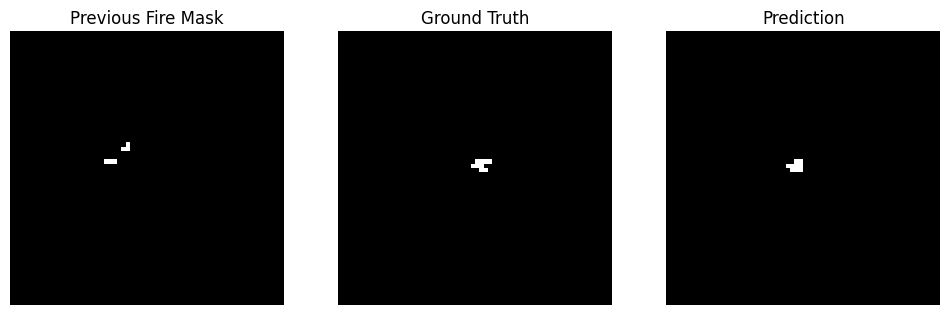

In [136]:
show_prediction(model, val_loader)

In [138]:
evaluate(model, val_loader)

Pixel Accuracy: 0.9643, IoU: 0.1898
